In [1]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

def load_images(image_folder):
    images = []
    for image_file in sorted(os.listdir(image_folder)):
        if image_file.endswith('.jpg') or image_file.endswith('.jpeg') or image_file.endswith('.png'):
            image_path = os.path.join(image_folder, image_file)
            image = Image.open(image_path).convert('RGB')
            image = image.resize((256, 256))  # Resize images to a fixed size
            image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
            images.append(image)
    return np.array(images)

def create_dataset(cleaned_images_dir, baseline_images_dir, condition_dir):
    cleaned_images = load_images(cleaned_images_dir)
    baseline_images = load_images(baseline_images_dir)
    condition_images = load_images(condition_dir)
    
    # Combine cleaned and condition images along the channel dimension
    X_combined = np.concatenate((cleaned_images, condition_images), axis=-1)
    
    X_train, X_test, y_train, y_test = train_test_split(X_combined, baseline_images, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Directories
cleaned_images_dir = 'cleaned_images'
baseline_images_dir = 'baseline_img'
condition_dir = 'condition'

# Create dataset
X_train, X_val, X_test, y_train, y_val, y_test = create_dataset(cleaned_images_dir, baseline_images_dir, condition_dir)

# Ensure the shape of y is compatible with the model
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import matplotlib.pyplot as plt
import random

def combined_loss(y_true, y_pred):
    bce = BinaryCrossentropy()(y_true, y_pred)
    mse = MeanSquaredError()(y_true, y_pred)
    return bce + 0.1 * mse

def unet_model(input_size=(256, 256, 6)):  # Adjust input size to match combined images
    inputs = layers.Input(input_size)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(3, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs, conv9)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=combined_loss, metrics=['accuracy'])
    
    return model

# Initialize and train the model
model = unet_model()

In [13]:
history = model.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_val, y_val))

Epoch 1/50
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.5744 - loss: 0.1979 - val_accuracy: 0.9766 - val_loss: 0.0388
Epoch 2/50
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9733 - loss: 0.0337 - val_accuracy: 0.9991 - val_loss: 0.0316
Epoch 3/50
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9991 - loss: 0.0297 - val_accuracy: 0.9991 - val_loss: 0.0281
Epoch 4/50
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9991 - loss: 0.0265 - val_accuracy: 0.9991 - val_loss: 0.0239
Epoch 5/50
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9991 - loss: 0.0222 - val_accuracy: 0.9991 - val_loss: 0.0206
Epoch 6/50
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9991 - loss: 0.0188 - val_accuracy: 0.9990 - val_loss: 0.0178
Epoch 7/50
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9988 - loss: 0.0162 - val_accuracy: 0.9990 - val_loss: 0.0162
Epoch 8/50
2835/2835 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9988 -


KeyboardInterrupt



25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


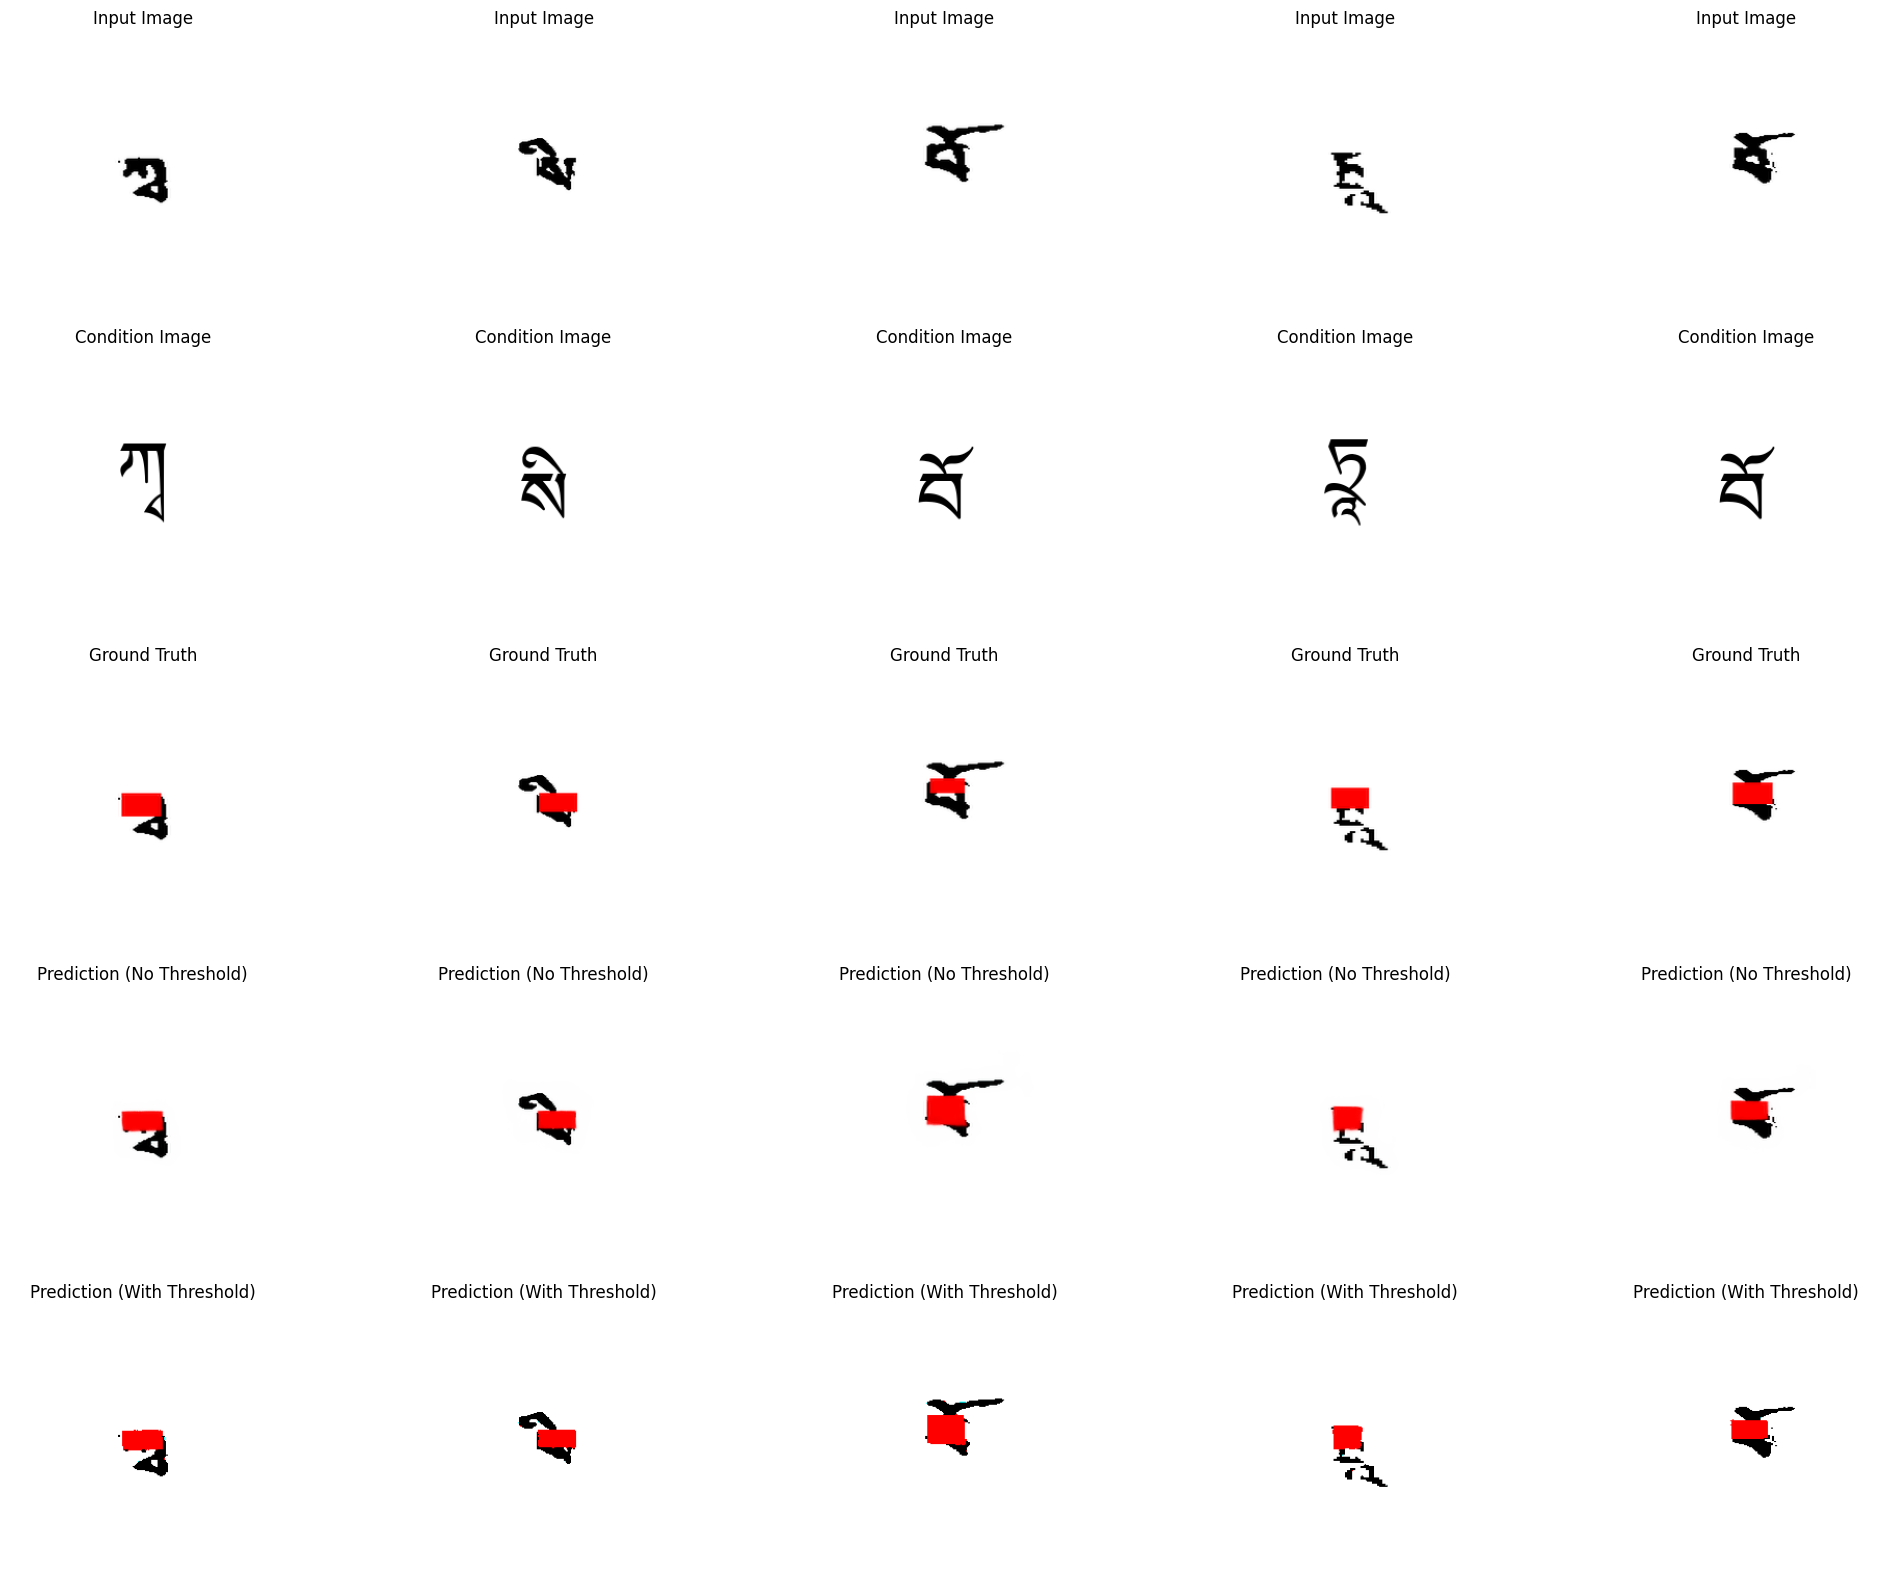

In [18]:
def apply_threshold(image, threshold=0.5):
    return (image > threshold).astype(np.float32)

def display_sample_predictions(model, X_test, y_test):
    predictions = model.predict(X_test)
    n_samples = 5
    plt.figure(figsize=(25, 20))
    for i in range(n_samples):
        idx = random.randint(0, len(X_test) - 1)
        
        plt.subplot(5, n_samples, i + 1)
        plt.title("Input Image")
        plt.imshow(X_test[idx, :, :, :3])  # Show the cleaned image part
        plt.axis('off')
        
        plt.subplot(5, n_samples, i + n_samples + 1)
        plt.title("Condition Image")
        plt.imshow(X_test[idx, :, :, 3:6])  # Show the glyph image part
        plt.axis('off')

        plt.subplot(5, n_samples, i + 2 * n_samples + 1)
        plt.title("Ground Truth")
        plt.imshow(y_test[idx])
        plt.axis('off')

        plt.subplot(5, n_samples, i + 3 * n_samples + 1)
        plt.title("Prediction (No Threshold)")
        plt.imshow(predictions[idx])
        plt.axis('off')

        plt.subplot(5, n_samples, i + 4 * n_samples + 1)
        plt.title("Prediction (With Threshold)")
        plt.imshow(apply_threshold(predictions[idx]))
        plt.axis('off')
    plt.show()

# Display sample predictions
display_sample_predictions(model, X_test, y_test)